# Scistree2 Tutorial
This tutorial is consist of two parts. Part I introduces the usage of Scistree2 with a toy example. 
Part II will help you go through the entire analysis for a high-grade serous ovarian carcinoma dataset as shown in paper "ScisTree2: An Improved Method for Large-scale Inference of Cell Lineage Trees and Genotype Calling from Noisy Single Cell Data". 

- Scistree2 binary file can be obtained from Github: https://github.com/yufengwudcs/ScisTree2

- HGSOC dataset can be downloaded at https://zenodo.org/records/3445364

- Other utils: get `popgen` from https://github.com/haotianzh/popgen

Once you get the dataset, please put uncompressed files, Scistree2 binary, `popgen` source folder, and this tutorial in the same folder.
This dataset was also analysed by HUNTRESS, you can compare our results with theirs if interested.

---

# Part I): Toy example

In [ ]:
# Here, we provide a python interface for calling Scistree2. input should be a numpy.ndarray, value denotes the probability of being wild type.
import os 
import multiprocessing as mp
import uuid
import numpy as np
import subprocess as sp
import popgen


class ScisTree2():
    def __init__(self, bin_path='/path/to/ScisTree2/ScisTree2-source-code/scistree', 
                 threads=-1, nj=False, spr=True, nni=False, iterative=False, verbose=True):
        self.cmd = self.build_cmd(bin_path, threads, nj, nni, verbose)
        
    def build_cmd(self, bin_path, threads, nj, nni, verbose):
        if threads == -1:
            threads = mp.cpu_count()
        cmd = [bin_path, '-T', str(threads)]
        return cmd 
    
    """
    IO: Write the genotype matrix to a file.
    """
    def write_to_scistree(self, genotype_matrix):
        nsite, ncell = genotype_matrix.shape
        prefix = uuid.uuid4()
        output = f'{prefix}.scistree.out'
        with open(output, 'w') as out:
            out.write(f'HAPLOID {nsite} {ncell}')
            for i in range(ncell):
                out.write(f' {i}')
            out.write('\n')
            for i in range(nsite):
                out.write(f's{i}')
                for j in range(ncell):
                    prob = genotype_matrix[i, j]
                    out.write(f' {prob:.5f}')
                out.write('\n')
        return output
    
    """
    Get the genotype matrix from the output of Scistree2
    """
    def get_scistree_genotype(self, prefix):
        geno_file = f'{prefix}.genos.imp'
        genotypes = []
        with open(geno_file, 'r') as f:
            for line in f.readlines():
                if line.startswith('Site'):
                    line = line.strip()
                    genos = line.split('\t')[1].split()
                    genos = list(map(int, genos))
                    genotypes.append(genos)
        return np.array(genotypes)
    
    def __call__(self, geno):
        output = self.write_to_scistree(geno)
        cmd = self.cmd + [f'{output}']
        cmd = ' '.join(cmd)
        res = sp.run(cmd, shell=True, stdout=sp.PIPE, encoding='utf-8').stdout.strip().split('\n')
        time = float(res[-1].split('=')[1].split('seconds')[0])
        nwk = res[-2].split(':')[1].strip() + ';'
        ml = float(res[-4].split(',')[0].split(':')[1])
        imp_geno = self.get_scistree_genotype(output)
        return imp_geno, nwk, ml, time

In [3]:
# init a caller
caller = ScisTree2()

# use a toy example
genotype = np.array([   [0.01, 0.6, 0.08, 0.8, 0.7],
                        [0.8, 0.02, 0.7, 0.01, 0.3],
                        [0.02, 0.8, 0.02, 0.8, 0.9],
                        [0.9, 0.9, 0.8, 0.8, 0.02],
                        [0.01, 0.8, 0.01, 0.8, 0.9],
                        [0.05, 0.02, 0.7, 0.05, 0.9]]) 
imputed_genotype, tree, ml, time = caller(genotype)
print('imputed_genotype: \n', imputed_genotype)
print('newick of inferred tree: ', tree)
print('maximum likelihood: ', ml)
print('time: ', time)

imputed_genotype: 
 [[1 0 1 0 0]
 [0 1 0 1 0]
 [1 0 1 0 0]
 [0 0 0 0 1]
 [1 0 1 0 0]
 [1 1 1 1 0]]
newick of inferred tree:  (((1,3),(2,4)),5);
maximum likelihood:  -6.27126
time:  0.0


In [8]:
# take a look at inferred tree
t = popgen.utils.from_newick(tree)
t.draw()

   f6f0b4296c                                      
 ┌─────┴───────────────────────┐                   
 5                         6e7d84fa36              
                   ┌───────────┴───────────┐       
               9f3737b2cb              f42c2eadc5  
             ┌─────┴─────┐           ┌─────┴─────┐ 
             4           2           3           1 


# Part II): HGSOC

## Inputs preparetion and Excution

In [1]:
# load some libraries for data manipulation and visualization
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from datetime import date

/home/haz19024/.venv/work/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
"""
Load SNV counts from a CSV file
"""
df = pd.read_csv('./ov2295_snv_counts.csv') # load SNV counts 
df = df.astype({'chrom': 'str', 
                'coord': 'int32', 
                'ref': 'str',
                'alt': 'str',
                'ref_counts': 'int32',
                'alt_counts': 'int32'})
df['snp_id'] = df['chrom'] + ':' + df['coord'].astype(str) + ':' + df['ref'] + ':' + df['alt'] # create a unique identifier for each SNV

/home/haz19024/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
"""
Calculate the posterior probability of each SNV being a true positive.

We use GATK likelihood with ADO included as described in CellCoal manual (https://dapogon.github.io/cellcoal/cellcoal.manual.v1.1.html#537_genotype_likelihoods)
    P(D|G={g_1, g_2}) = (1-ado)\prod_{i=1}^{r}P(b_i|G={g_1, g_2}) + 0.5*ado[\prod_{i=1}^{r}P(b_i|G={g_1}) + \prod_{i=1}^{r}P(b_i|G={g_2})]
"""

def posterior_prob_with_ado_seqerr_gt(ref_counts, alt_counts, prior_ref=0.5, ado=0.2, seqerr=0.01, margin=1e-5):
    p00, p01, p10, p11 = np.log(1-seqerr), np.log(seqerr), np.log(seqerr), np.log(1-seqerr)
    l00 = np.exp(ref_counts*p00 + alt_counts*p01)
    l01 = (1-ado)*np.exp(ref_counts*np.log(0.5*np.exp(p00)+0.5*np.exp(p10))+alt_counts*np.log(0.5*np.exp(p01)+0.5*np.exp(p11)))+(0.5*ado)*(np.exp(ref_counts*p00+alt_counts*p10)+np.exp(ref_counts*p10+alt_counts*p11))
    l11 = np.exp(ref_counts*p10 + alt_counts*p11)
    g00 = prior_ref**2 * l00
    g01 = 2*(1-prior_ref)*prior_ref * l01
    g11 = (1-prior_ref)**2 * l11
    prob =  max(min(np.round(g00/(g00+g01+g11), 5), 1-margin), margin)
    return prob

"""
Calculate the phred-scaled likelihood of each SNV, this is required by CellPhy GT10 model.
"""
def phred_likelihood_with_ado_seqerr_gt(ref_counts, alt_counts, ado=0.2, seqerr=0.01):
    # Q-phred score = -10 * log10(p)
    p00, p01, p10, p11 = np.log(1-seqerr), np.log(seqerr), np.log(seqerr), np.log(1-seqerr)
    l00 = np.exp(ref_counts*p00 + alt_counts*p01)
    l01 = (1-ado)*np.exp(ref_counts*np.log(0.5*np.exp(p00)+0.5*np.exp(p10))+alt_counts*np.log(0.5*np.exp(p01)+0.5*np.exp(p11)))+(0.5*ado)*(np.exp(ref_counts*p00+alt_counts*p10)+np.exp(ref_counts*p10+alt_counts*p11))
    l11 = np.exp(ref_counts*p10 + alt_counts*p11)
    q00 = int(-10 * np.log10(l00))
    q11 = int(-10 * np.log10(l11))
    q01 = int(-10 * np.log10(l01))
    return q00, q01, q11


In [4]:
# There are 3 samples [SA921, SA922, SA1090]. Check the number of cells for each sample
for sample in df['sample_id'].unique():
    print(sample, df[df['sample_id'] == sample]['cell_id'].unique().shape[0])

SA921 616
SA922 588
SA1090 739


In [5]:
# Optional: according to preclustered clones, we filter out the cells that are not in the clone clusters.
# Note: You can skip this step if you don't have clone information, since Scistree2 is a poweful tool designed to be run without preclustering. 
df_clones = pd.read_csv('./ov2295_clone_clusters.csv')
filtered_cells = df_clones['cell_id'].unique()
df = df[df['cell_id'].isin(filtered_cells)]

In [6]:
# Filter out non-informative sites, criterion: more than 650 cells are missed
informative_df = df.groupby('snp_id').size().sort_values(ascending=False)
informative_sites = informative_df[informative_df > len(filtered_cells) - 650].index.tolist()
df = df[df['snp_id'].isin(informative_sites)]

In [7]:
# Preview on processed data
cells = df['cell_id'].drop_duplicates().tolist()
sites = df['snp_id'].drop_duplicates().tolist()
cells = sorted(cells)
sites = sorted(sites)
print(len(cells), len(sites))

891 789


In [8]:
# Check the number of cells and the number of sites again, there are 891 cells with 744 mutations in HUNTRESS, a slight difference.
cells = df['cell_id'].drop_duplicates().tolist()
sites = df['snp_id'].drop_duplicates().tolist()
print(len(cells), len(sites))
prefix = f'ov2295_{len(sites)}_{len(cells)}'
print(prefix)

891 789
ov2295_789_891


In [9]:
# Create a dataframe of meta information for each SNP.
df_site_meta = df[['snp_id', 'chrom', 'coord', 'ref', 'alt']].drop_duplicates()
df_site_meta.sort_values(by='snp_id', inplace=True)
df_site_meta['id'] = [f's{ix}' for ix in np.arange(df_site_meta.shape[0])]
df_site_meta.to_csv(f'./{prefix}_meta_site.csv', index=False)

In [10]:
# Create a dataframe of meta information for each cell.
df_cell_meta = df[['cell_id', 'sample_id']].drop_duplicates().sort_values(by='cell_id')
df_cell_meta['id'] = [ix for ix in np.arange(df_cell_meta.shape[0])]
df_cell_meta = pd.merge(df_cell_meta, df_clones, on='cell_id')
df_cell_meta.to_csv(f'./{prefix}_meta_cell.csv', index=False)

In [11]:
"""
Get the maximum-likelihood genotype for each site.
"""
def get_ml_gt(ref_counts, alt_counts):
    a, b, c = phred_likelihood_with_ado_seqerr_gt(ref_counts, alt_counts)
    min_phred = min(a, b, c) 
    if a == min_phred:
        return 0
    elif b == min_phred:
        return 1
    else:
        return 2

df['ml_gt'] = df.apply(lambda x: get_ml_gt(x['ref_counts'], x['alt_counts']), axis=1) 

In [12]:
"""
Get the phred likelihood for each site.
"""
def get_phred_likelihood(ref_counts, alt_counts, ml_gt):
    gts = ['0/0', '0/1', '1/1']
    a, b, c = phred_likelihood_with_ado_seqerr_gt(ref_counts, alt_counts)
    return f'{gts[ml_gt]}:{a},{b},{c}'

df['phred'] = df.apply(lambda x: get_phred_likelihood(x['ref_counts'], x['alt_counts'], x['ml_gt']), axis=1)

In [13]:
"""
 Calculate the allele frequency for each site.
"""
def af(gts):
    counts = [0, 0, 0]
    for gt in gts:
        counts[gt] += 1
    counts = np.array(counts)
    freqs = counts / sum(counts)
    return np.round(freqs[0] + 0.5 * freqs[1], 2)

allele_freqs = df.groupby('snp_id')['ml_gt'].agg(func=af).to_frame().rename(columns={'ml_gt': 'af'})
df = df.join(allele_freqs, on='snp_id')
df_site_meta = df_site_meta.join(allele_freqs, on='snp_id')
df_site_meta.to_csv('./meta_site.csv', index=False)

In [14]:
# Calculate the posterior probability for each site
df['genotype_prob'] = df.apply(lambda x: posterior_prob_with_ado_seqerr_gt(x['ref_counts'], x['alt_counts'], prior_ref=x['af']), axis=1)

In [15]:
"""
IO: Write the genotype matrix to a file.
"""
def write_to_scistree(genotype_matrix):
    nsite, ncell = genotype_matrix.shape
    output = f'ov2295_{nsite}_{ncell}.scistree'
    with open(output, 'w') as out:
        out.write(f'HAPLOID {nsite} {ncell}')
        for i in range(ncell):
            out.write(f' {i}')
        out.write('\n')
        # for i in range(self.nsite):
        # idx = 1
        for i in range(nsite):
            out.write(f's{i}')
            # idx += 1
            for j in range(ncell):
                prob = genotype_matrix[i, j]
                out.write(f' {prob:.5f}')
            out.write('\n')

"""
IO: Write the genotype matrix to a file.
"""
def write_to_huntress(matrix):
    flags = [0, 1, 1, 3]
    nsite, ncell = matrix.shape
    output = f'ov2295_{nsite}_{ncell}.huntress'
    with open(output, 'w') as out:
        out.write(f'cellID/mutID')
        for i in range(nsite):
            out.write(f'\ts{i}')
        out.write('\n')
        for i in range(ncell):
            out.write(f'c{i}')
            for j in range(nsite):
                val = flags[int(matrix[j, i])]
                out.write(f'\t{val}')
            out.write('\n')

"""
IO: Write the genotype matrix to a file.
"""
def write_to_cellphy(matrix):
    nsite, ncell = matrix.shape
    output = f'ov2295_{nsite}_{ncell}.vcf'
    header = \
f'''##fileformat=VCFv4.3
##fileDate={date.today().isoformat()}
##source=ov2295
##ncell={ncell}
##nsite={nsite}
##reference=NONE
##contig=<ID=1>
##phasing=NO
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
##FORMAT=<ID=PL,Number=G,Type=Integer,Description="Phread-scaled genotype likelihoods">
'''
    with open(output, 'w') as out:
        out.write(header)
        out.write('#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT')
        for i in range(ncell):
            out.write(f'\t{i}')
        out.write('\n')
        for i in range(nsite):
            chrom, coord, ref, alt, af, snp_id = df_site_meta.iloc[i][['chrom', 'coord', 'ref', 'alt', 'af', 'id']]
            out.write(f"{chrom}\t{coord}\t{snp_id}\t{ref}\t{alt}\t.\tPASS\tAF={af}\tGT:PL")
            for j in range(ncell):
                out.write(f'\t{matrix[i, j]}')
            out.write('\n')                               

In [17]:
# Prepare Scistree2's inputs
scistree_matrix_df = df.pivot(index='snp_id', columns='cell_id', values='genotype_prob')
scistree_matrix = scistree_matrix_df.to_numpy()
genotype_matrix_scistree = np.nan_to_num(scistree_matrix, nan=0.5)
write_to_scistree(genotype_matrix_scistree) 

In [18]:
# Prepare HUNTRESS's inputs
huntress_matrix_df = df.pivot(index='snp_id', columns='cell_id', values='ml_gt')
huntress_matrix = huntress_matrix_df.to_numpy()
huntress_matrix = np.nan_to_num(huntress_matrix, nan=3)
write_to_huntress(huntress_matrix)

In [19]:
# Prepare Cellphy's inputs
cellphy_matrix_df = df.pivot(index='snp_id', columns='cell_id', values='phred') 
cellphy_matrix_df.fillna('./.:0,0,0', inplace=True)
cellphy_matrix = cellphy_matrix_df.to_numpy()
write_to_cellphy(cellphy_matrix)
# cellphy_matrix_df

In [ ]:
# Run Scistree2 with 30 threads
input_scis = f'{prefix}.scistree'
! /usr/bin/time -o {prefix}.scistree.time /path/to/scistree -v -T 30 -e -o {prefix}.prob.muttree.gml $input_scis > {prefix}.scistree.log

In [ ]:
# Run HUNTRESS with 30 threads
input_huntress = f'{prefix}.huntress'
! /usr/bin/time -o {prefix}.huntress.time python /path/to/HUNTRESS/HUNTRESS.py --i $input_huntress --o {prefix}.SC --t 30 > {prefix}.HUNTRESS.log

In [22]:
# Run Cellphy with 30 threads
input_cellphy = f'{prefix}.vcf'
! /usr/bin/time -o {prefix}.cellphy.time /path/to/cellphy/cellphy.sh FAST -a -t 30 -r $input_cellphy > {prefix}.cellphy.log 2>&1

## Results analysis and visulization

In [16]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import pickle
import popgen

In [ ]:
# If you want to annotate the SNVs, you can use ANNOVAR. Installation can befoudn at https://annovar.openbioinformatics.org/en/latest/user-guide/download/

# Annovar annotation
humandb = '/path/to/annovar/humandb/humandb/'
xref = '/path/to/annovar/example/gene_fullxref.txt'
!perl /path/to/annovar/table_annovar.pl {prefix}.vcf $humandb -buildver hg19 -out {prefix} -remove -protocol refGene,cytoBand,exac03,avsnp147,dbnsfp30a -operation gx,r,f,f,f -nastring . -vcfinput -polish -xref $xref

In [17]:
# SNV annotation
df_gene_annotation = pd.read_table(f'../{prefix}.hg19_multianno.txt')
df_gene_annotation

,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,...,Otherinfo894,Otherinfo895,Otherinfo896,Otherinfo897,Otherinfo898,Otherinfo899,Otherinfo900,Otherinfo901,Otherinfo902,Otherinfo903
0,10,36258731,36258731,C,T,intergenic,PCAT5;ANKRD30A,dist=168883;dist=1156054,.,.,...,"./.:0,0,0","0/0:0,4,13","0/0:0,2,6","0/0:0,4,13","./.:0,0,0","0/0:0,2,6","./.:0,0,0","./.:0,0,0","./.:0,0,0","./.:0,0,0"
1,10,44790486,44790486,C,A,downstream,LINC02881,dist=389,.,.,...,"./.:0,0,0","./.:0,0,0","./.:0,0,0","./.:0,0,0","./.:0,0,0","1/1:40,10,8","./.:0,0,0","./.:0,0,0","./.:0,0,0","1/1:20,3,0"
2,10,47079935,47079935,G,T,intergenic,GPRIN2;NPY4R2,dist=72054;dist=1885,.,.,...,"./.:0,0,0","0/0:0,4,13","1/1:20,3,0","./.:0,0,0","./.:0,0,0","./.:0,0,0","./.:0,0,0","0/0:0,2,6","./.:0,0,0","./.:0,0,0"
3,10,50851414,50851414,C,A,intronic,CHAT,.,.,.,...,"./.:0,0,0","0/0:0,4,13","./.:0,0,0","./.:0,0,0","./.:0,0,0","./.:0,0,0","./.:0,0,0","./.:0,0,0","./.:0,0,0","./.:0,0,0"
4,10,79932700,79932700,A,T,intergenic,RPS24;LINC00856,dist=116136;dist=75682,.,.,...,"0/0:0,2,6","./.:0,0,0","./.:0,0,0","0/0:0,4,13","./.:0,0,0","./.:0,0,0","./.:0,0,0","./.:0,0,0","./.:0,0,0","./.:0,0,0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,8,97876720,97876720,T,C,intronic,CPQ,.,.,.,...,"1/1:40,10,8","./.:0,0,0","./.:0,0,0","0/0:0,4,13","./.:0,0,0","./.:0,0,0","./.:0,0,0","1/1:20,3,0","./.:0,0,0","./.:0,0,0"
785,8,98325993,98325993,A,T,ncRNA_intronic,LOC101927066,.,.,.,...,"0/0:0,6,20","./.:0,0,0","./.:0,0,0","./.:0,0,0","0/0:0,4,13","0/0:0,2,6","./.:0,0,0","0/0:0,2,6","0/0:0,2,6","./.:0,0,0"
786,8,98413399,98413399,C,T,ncRNA_intronic,LOC101927066,.,.,.,...,"./.:0,0,0","0/1:20,6,7","0/0:0,2,6","1/1:40,7,1","./.:0,0,0","./.:0,0,0","1/1:20,3,0","./.:0,0,0","./.:0,0,0","1/1:20,3,0"
787,8,99166875,99166875,G,A,intronic,POP1,.,.,.,...,"./.:0,0,0","0/0:0,2,6","0/0:0,4,13","0/1:20,6,7","./.:0,0,0","./.:0,0,0","./.:0,0,0","./.:0,0,0","./.:0,0,0","./.:0,0,0"


In [18]:
# Load the precomputed clonal tree with node information in the HGSOC dataset
with open('./ov2295_tree.pickle', 'rb') as f:
    tree = pickle.load(f)
df_nodes = pd.read_csv('./ov2295_nodes.csv')
df_mutations = pd.merge(df_nodes, df_site_meta, left_on='variant_id', right_on='snp_id') # merge the node information with the SNV information
df_mutations

,variant_id,node,loss,origin,presence,ml_origin,ml_presence,ml_loss,snp_id,chrom,coord,ref,alt,id,af
0,10:36258731:C:T,0,0.000000e+00,4.567698e-05,0.000000e+00,0,0,0,10:36258731:C:T,10,36258731,C,T,s0,0.91
1,10:36258731:C:T,1,4.536726e-05,6.020528e-98,3.097139e-07,0,0,0,10:36258731:C:T,10,36258731,C,T,s0,0.91
2,10:36258731:C:T,2,3.076417e-07,5.940235e-98,2.072204e-09,0,0,0,10:36258731:C:T,10,36258731,C,T,s0,0.91
3,10:36258731:C:T,3,2.072204e-09,3.062727e-106,0.000000e+00,0,0,0,10:36258731:C:T,10,36258731,C,T,s0,0.91
4,10:36258731:C:T,4,2.072204e-09,7.672154e-107,0.000000e+00,0,0,0,10:36258731:C:T,10,36258731,C,T,s0,0.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13408,8:99770344:A:C,12,3.417474e-07,2.554902e-65,2.345168e-09,0,0,0,8:99770344:A:C,8,99770344,A,C,s788,0.93
13409,8:99770344:A:C,13,2.323599e-09,3.455902e-65,2.156852e-11,0,0,0,8:99770344:A:C,8,99770344,A,C,s788,0.93
13410,8:99770344:A:C,14,2.128003e-11,5.044326e-65,2.877698e-13,0,0,0,8:99770344:A:C,8,99770344,A,C,s788,0.93
13411,8:99770344:A:C,15,1.586328e-11,1.338978e-63,5.705658e-12,0,0,0,8:99770344:A:C,8,99770344,A,C,s788,0.93


In [19]:
# Obtain the Ancestor - Descendent relationships in the given HGSOC clonal tree
orders_nodes = {}
for node in tree.nodes:
    orders_nodes[node.label] = []
    for d in node.descendents:
        orders_nodes[node.label].append(d.label)
orders_nodes

{0: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 1: [2, 3, 4, 5, 6, 7],
 2: [3, 4],
 3: [],
 4: [],
 5: [6, 7],
 6: [],
 7: [],
 8: [9, 10, 11, 12, 13, 14, 15, 16],
 9: [10, 11],
 10: [],
 11: [],
 12: [13, 14, 15, 16],
 13: [14, 15],
 14: [],
 15: [],
 16: []}

In [20]:
# Double check that each mutation occurs exactly once
(df_mutations.groupby(['variant_id']).sum()['ml_origin'] == 1).all()
# Find the node that each mutation originates from
df_origin = df_mutations.groupby(['variant_id']).apply(lambda x: x[x['ml_origin']==1])
df_origin = df_origin.set_index('variant_id')
df_origin

,node,loss,origin,presence,ml_origin,ml_presence,ml_loss,snp_id,chrom,coord,ref,alt,id,af
variant_id,,,,,,,,,,,,,,
10:36258731:C:T,12,6.020910e-98,0.993219,0.006781,1,1,0,10:36258731:C:T,10,36258731,C,T,s0,0.91
10:44790486:C:A,0,0.000000e+00,1.000000,0.000000,1,1,0,10:44790486:C:A,10,44790486,C,A,s1,0.41
10:47079935:G:T,0,0.000000e+00,1.000000,0.000000,1,1,0,10:47079935:G:T,10,47079935,G,T,s2,0.77
10:50851414:C:A,1,1.655850e-176,0.993264,0.006736,1,1,0,10:50851414:C:A,10,50851414,C,A,s3,0.83
10:79932700:A:T,0,0.000000e+00,1.000000,0.000000,1,1,0,10:79932700:A:T,10,79932700,A,T,s4,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8:97876720:T:C,9,1.347097e-137,0.993095,0.006905,1,1,0,8:97876720:T:C,8,97876720,T,C,s784,0.86
8:98325993:A:T,12,4.809655e-113,0.993210,0.006790,1,1,0,8:98325993:A:T,8,98325993,A,T,s785,0.87
8:98413399:C:T,9,7.527466e-144,0.993211,0.006789,1,1,0,8:98413399:C:T,8,98413399,C,T,s786,0.86


In [21]:
import re
"""
Get the genotype matrix from the output of Scistree2
"""
def get_scistree_genotype(prefix):
    geno_file = f'{prefix}.scistree.genos.imp'
    genotypes = []
    with open(geno_file, 'r') as f:
        for line in f.readlines():
            if line.startswith('Site'):
                line = line.strip()
                genos = line.split('\t')[1].split()
                genos = list(map(int, genos))
                genotypes.append(genos)
    return np.array(genotypes)


"""
Get the genotype matrix from the output of HUNTRESS
"""
def get_huntress_genotype(prefix):
    geno_file = f'{prefix}.SC.CFMatrix'
    genotypes = pd.read_table(geno_file, index_col=0).values.T
    return genotypes

"""
Get the mutation list from the output of Cellphy
"""
def read_mutation_list(file):
    edges = {}
    with open(file, 'r') as f:
        for line in f.readlines():
            items = line.strip().split()
            if int(items[1]) > 0:
                eid, num_muts, muts = items
                edges[eid] = [int(_[1:]) for _ in muts.split(',')]
            else:
                eid = items[0]
                edges[eid] = []
    return edges


"""
Get the mutation tree from the output of Cellphy
"""
def read_mutation_tree(file):
    with open(file, 'r') as f:
        line = f.readline()
        line = line.strip()
    return popgen.utils.from_newick(line)

"""
Get the genotype matrix from the output of Cellphy
"""
def get_cellphy_genotype(prefix):
    raxml_tree = f'{prefix}.vcf.Mapped.raxml.mutationMapTree'
    raxml_list = f'{prefix}.vcf.Mapped.raxml.mutationMapList'
    num_snp, num_cell = len(sites), len(cells)
    genotype = np.zeros([num_snp, num_cell], dtype=int)
    edges = read_mutation_list(raxml_list)
    tree = read_mutation_tree(raxml_tree)
    generator = popgen.utils.TraversalGenerator(order='post')
    for node in generator(tree):
        if not node.is_root():
            eid = re.search(r'\[(\d+)\]', node.branch).group(1)
            muts = edges[eid]
            # muts = [mut-1 for mut in muts] # to 0-indexed
            leaves = [int(leaf.name) for leaf in node.get_leaves()] # to 0-indexed
            genotype[np.ix_(muts, leaves)] = 1
    return genotype

In [31]:
def _assign(ids, x):
    # print(x)
    chr = x['chrom']
    coord = x['coord']
    k = f'{chr}:{coord}'
    ids[k] = x['id']

# conversion for mutationlist of cellphy
def convert_to_id(mut_file, out_path=f'{prefix}.vcf.Mapped.raxml.mutationMapList'):
    cellphy_ids = {}
    df_origin.apply(lambda x: _assign(cellphy_ids, x), axis=1)
    with open(out_path, 'w') as out:
        with open(mut_file, 'r') as f:
            for line in f.readlines():
                items = line.strip().split()
                ix, num = items[0], int(items[1])
                if num != 0:
                    muts = [cellphy_ids[mut] for mut in items[2].split(',')]
                    muts = ','.join(muts)
                else:
                    muts = ''
                new_line = f'{ix}\t{num}\t{muts}\n'
                out.write(new_line)
    
# convert_to_id(f'{prefix}.vcf.Mapped.raxml.mutationMapList.swp')

In [22]:
# grab all inferred genotypes
cellphy_genotype = get_cellphy_genotype(prefix)
huntress_genotype = get_huntress_genotype(prefix)
scistree_genotype = get_scistree_genotype(prefix)
print(cellphy_genotype.shape, huntress_genotype.shape, scistree_genotype.shape)


(789, 891) (789, 891) (789, 891)


In [23]:
sites = sorted(sites)
# Get all Ancestor-Descendent pairs in the clonal tree in the HGSOC dataset
def precede(s1, s2):
    n1, n2 = df_origin.loc[s1, 'node'], df_origin.loc[s2, 'node']
    if n2 in orders_nodes[n1]:
        return 0
    if n1 in orders_nodes[n2]:
        return 1
    return 2

true_mutations = {f's{_}': [] for _ in range(len(sites))}
for i in range(len(sites)):
    for j in range(i+1, len(sites)):
        res = precede(sites[i], sites[j])
        if res == 0:
            true_mutations[f's{i}'].append(f's{j}')
        elif res == 1:
            true_mutations[f's{j}'].append(f's{i}')


In [24]:
"""
Check if clade1 covers clade2.
"""
def is_covered(clade1, clade2):
    diff = clade1 - clade2
    if 0 in diff and 1 in diff and -1 in diff:
        return 0 # no relationship
    if 1 in diff:
        return 1 # clade1(snp1) happens before clade2(snp2)
    else:
        return -1 # clade2(snp2) happens before clade1(snp1)

"""
Get AD pairs from given genotype matrix.
"""
def get_ancestor_descendant_pairs(geno):
    num_snp, _ = geno.shape
    mutations = {f's{_}': [] for _ in range(num_snp)}
    for i in range(num_snp):
        for j in range(i+1, num_snp):
            code = is_covered(geno[i], geno[j])
            if code == 1:
                mutations[f's{i}'].append(f's{j}')
            elif code == -1:
                mutations[f's{j}'].append(f's{i}')
    return mutations

"""
Calculate the error rate for Ancestor-Descendant pairs.
"""
def ancestor_descendant_error(mutation1, mutation2):
    count = 0
    total = 0
    for snp1 in mutation1:
        for snp2 in mutation1[snp1]:
            count += int(snp2 not in mutation2[snp1])
            total += 1
    return count / total

"""
Calculate the error rate for Different-Lineage pairs.
"""
def different_lineage_error(mutation1, mutation2):
    count = 0
    total = 0
    muts = list(mutation1.keys())
    num_mut = len(muts)
    for i in range(num_mut):
        for j in range(i+1, num_mut):
            if muts[i] not in mutation1[muts[j]] and muts[j] not in mutation1[muts[i]]:
                count += int(muts[j] in mutation2[muts[i]]) + int(muts[i] in mutation2[muts[j]])
                total += 1
    return count / total

In [25]:
scistree_mutations = get_ancestor_descendant_pairs(scistree_genotype)
huntress_mutations = get_ancestor_descendant_pairs(huntress_genotype)
cellphy_mutations = get_ancestor_descendant_pairs(cellphy_genotype)

In [26]:
# Ancestor-Descendent accuracy and precision
scistree_ad_acc = 1 - ancestor_descendant_error(true_mutations, scistree_mutations)
scistree_ad_pre = 1 - ancestor_descendant_error(scistree_mutations, true_mutations)
huntress_ad_acc = 1 - ancestor_descendant_error(true_mutations, huntress_mutations)
huntress_ad_pre = 1 - ancestor_descendant_error(huntress_mutations, true_mutations)
cellphy_ad_acc = 1 - ancestor_descendant_error(true_mutations, cellphy_mutations)
cellphy_ad_pre = 1 - ancestor_descendant_error(cellphy_mutations, true_mutations)


# Different-Lineage accuracy and precision
scistree_dl_acc = 1 - different_lineage_error(true_mutations, scistree_mutations)
scistree_dl_pre = 1 - different_lineage_error(scistree_mutations, true_mutations)
huntress_dl_acc = 1 - different_lineage_error(true_mutations, huntress_mutations)
huntress_dl_pre = 1 - different_lineage_error(huntress_mutations, true_mutations)
cellphy_dl_acc = 1 - different_lineage_error(true_mutations, cellphy_mutations)
cellphy_dl_pre = 1 - different_lineage_error(cellphy_mutations, true_mutations)


def f1_score(pre, acc):
    return 2 / (1/pre + 1/acc)

# F1 score
scsitree_ad_f1 = f1_score(scistree_ad_pre, scistree_ad_acc)
huntress_ad_f1 = f1_score(huntress_ad_pre, huntress_ad_acc)
cellphy_ad_f1 = f1_score(cellphy_ad_pre, cellphy_ad_acc)
scistree_dl_f1 = f1_score(scistree_dl_pre, scistree_dl_acc)
huntress_dl_f1 = f1_score(huntress_dl_pre, huntress_dl_acc)
cellphy_dl_f1 = f1_score(cellphy_dl_pre, cellphy_dl_acc)

In [27]:
methods = ['ScisTree'] * 6 + ['HUNTRESS'] * 6   + ['CellPhy'] * 6
measures = ['Ancestor-Descendent Accuracy',
            'Ancestor-Descendent Precision',
            'Different-Lineage Accuracy',
            'Different-Lineage Precision',
            'Ancestor-Descendent F1-Score',
            'Different-Lineage F1-Score'] * 3
vals = [scistree_ad_acc, scistree_ad_pre, scistree_dl_acc, scistree_dl_pre, scsitree_ad_f1, scistree_dl_f1,
        huntress_ad_acc, huntress_ad_pre, huntress_dl_acc, huntress_dl_pre, huntress_ad_f1, huntress_dl_f1,
        cellphy_ad_acc, cellphy_ad_pre, cellphy_dl_acc, cellphy_dl_pre, cellphy_ad_f1, cellphy_dl_f1
        ]
df_result = pd.DataFrame({'Method': methods, 'Measure': measures, 'Value': vals})
df_result

,Method,Measure,Value
0,ScisTree,Ancestor-Descendent Accuracy,0.937556
1,ScisTree,Ancestor-Descendent Precision,0.674161
2,ScisTree,Different-Lineage Accuracy,0.733573
3,ScisTree,Different-Lineage Precision,0.956050
4,ScisTree,Ancestor-Descendent F1-Score,0.784335
5,ScisTree,Different-Lineage F1-Score,0.830164
6,HUNTRESS,Ancestor-Descendent Accuracy,0.990460
7,HUNTRESS,Ancestor-Descendent Precision,0.619685
8,HUNTRESS,Different-Lineage Accuracy,0.641850
9,HUNTRESS,Different-Lineage Precision,0.997233


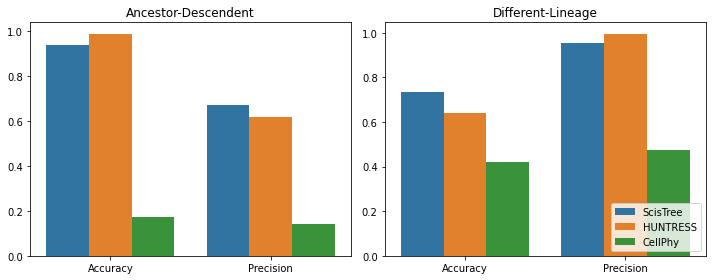

In [28]:
# plots
import seaborn as sns

fig, axes = plt.subplots(figsize=(10,4), nrows=1, ncols=2)

g1 = sns.barplot(ax=axes[0], data=df_result[df_result['Measure'].isin(['Ancestor-Descendent Accuracy', 'Ancestor-Descendent Precision'])], x='Measure', y='Value', hue='Method')
axes[0].set_title('Ancestor-Descendent')
axes[0].set_xlabel('')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Accuracy', 'Precision'])
axes[0].set_ylabel('')
g1.legend_.remove()
g2 = sns.barplot(ax=axes[1], data=df_result[df_result['Measure'].isin(['Different-Lineage Accuracy', 'Different-Lineage Precision'])], x='Measure', y='Value', hue='Method')
axes[1].set_title('Different-Lineage')
axes[1].set_xlabel('')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Accuracy', 'Precision'])
axes[1].set_ylabel('')
g2.legend(loc='lower right')
plt.tight_layout()

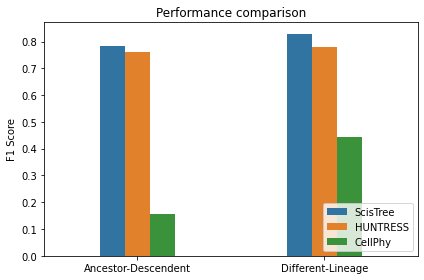

In [29]:
# f-score 
fig, ax = plt.subplots(figsize=(6,4), nrows=1, ncols=1)

g1 = sns.barplot(ax=ax, data=df_result[df_result['Measure'].isin(['Ancestor-Descendent F1-Score', 'Different-Lineage F1-Score'])], x='Measure', y='Value', hue='Method', width=0.4)
ax.set_title('Performance comparison')
ax.set_xlabel('')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Ancestor-Descendent', 'Different-Lineage'])
ax.set_ylabel('F1 Score')
ax.legend_.set_title('')
ax.legend(loc='lower right')
plt.tight_layout()


In [30]:
# running time
def get_running_time(file):
    with open(file) as f:
        line = f.readline().strip()
        user_time_str, _, real_time_str, *args = line.split()
        user_time = float(user_time_str.split('user')[0])
        real_time = .0
        real_time_str = real_time_str.split('elapsed')[0].split(':')[::-1]
        for i in range(len(real_time_str)):
            real_time += 60**i * float(real_time_str[i])
    return user_time, real_time

scsitree_user_time, scistree_real_time = get_running_time(f'{prefix}.scistree.time')  
huntress_user_time, huntress_real_time = get_running_time(f'{prefix}.huntress.time') 
cellphy_user_time, cellphy_real_time = get_running_time(f'{prefix}.cellphy.time')

methods = ['ScisTree'] * 2 + ['HUNTRESS'] * 2 + ['CellPhy'] * 2
measures = ['User Time', 'Elasped Time'] * 3
vals = [scsitree_user_time, scistree_real_time, huntress_user_time, huntress_real_time, cellphy_user_time, cellphy_real_time ]
df_time = pd.DataFrame({'Method': methods, 'Measure': measures, 'Value': vals})
df_time



,Method,Measure,Value
0,ScisTree,User Time,549.92
1,ScisTree,Elasped Time,100.50
2,HUNTRESS,User Time,5960.54
3,HUNTRESS,Elasped Time,277.64
4,CellPhy,User Time,208125.69
5,CellPhy,Elasped Time,6962.00


/tmp/ipykernel_735248/3541172569.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=12)
/tmp/ipykernel_735248/3541172569.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['User Time', 'Elapsed Time'], fontsize=16)
/tmp/ipykernel_735248/3541172569.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize=12)


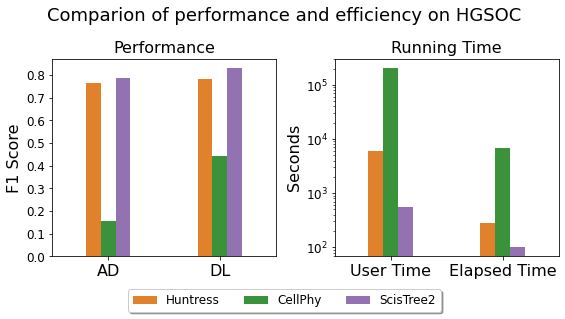

In [31]:
# time plot
font = {
'size' : 22}

# matplotlib.rc('font', **font)
tab10 = sns.color_palette('tab10')
palette = [tab10[1], tab10[2], tab10[4]]

fig, axes = plt.subplots(figsize=(8,4), nrows=1, ncols=2)

g1 = sns.barplot(ax=axes[0], data=df_result[df_result['Measure'].isin(['Ancestor-Descendent F1-Score', 'Different-Lineage F1-Score'])], x='Measure', y='Value', hue='Method', width=0.4, palette=palette, hue_order=['HUNTRESS', 'CellPhy', 'ScisTree'])
axes[0].set_title('Performance',  fontsize=16)
axes[0].set_xlabel('')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['AD', 'DL'],  fontsize=16)
axes[0].set_ylabel('F1 Score',  fontsize=16)
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=12)
axes[0].legend_ = None
# axes[0].legend_.set_title('')
# axes[0].legend(loc='lower right')
handles, labels = axes[0].get_legend_handles_labels()
g2 = sns.barplot(ax=axes[1], data=df_time, x='Measure', y='Value', hue='Method', width=0.4, palette=palette, hue_order=['HUNTRESS', 'CellPhy', 'ScisTree'])
axes[1].set_title('Running Time',  fontsize=16)
axes[1].set_xlabel('')
axes[1].set_xticklabels(['User Time', 'Elapsed Time'], fontsize=16)
axes[1].set_ylabel('Seconds',  fontsize=16)
axes[1].set_yscale('log')
axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize=12)
# axes[1].legend_.set_title('')
# axes[1].legend(loc='upper right')
axes[1].legend_.remove()
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5, handles=handles, labels=['Huntress', 'CellPhy', 'ScisTree2'], fontsize=12)
plt.suptitle('Comparion of performance and efficiency on HGSOC', fontsize=18)
plt.tight_layout()
